In [1]:
import dgl
import torch
import random
import Bio.PDB
from Bio.PDB.ResidueDepth import ResidueDepth
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob

In [2]:
RES_NAMES = {'ALA': 0, 'ARG': 1, 'ASN': 2, 'ASP': 3, 'CYS': 4, 'GLN': 5, 'GLU': 6, 'GLY': 7, 'HIS': 8, 'ILE': 9, 'LEU': 10, 'LYS': 11, 'MET': 12, 'PHE': 13, 'PRO': 14, 'SER': 15, 'THR': 16, 'TRP': 17, 'TYR': 18, 'VAL': 19}
OH_RES = np.identity(20)

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), np.float32)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

In [3]:
pdb_files = glob("./Data/deeploc_af2/*.pdb")
random.shuffle(pdb_files)

In [4]:
pdb_file = pdb_files[0]
contact_map = np.load(pdb_file.replace(".pdb", ".npy"))[0]
pdb_code = pdb_file.split("-")[-3].split(".")[0]
structure = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_file)
model = structure[0]

In [5]:
dist_matrix = calc_dist_matrix(model["A"], model["A"])
contact_map = dist_matrix < 10.0
len(model['A']), dist_matrix.shape, contact_map.shape

(101, (101, 101), (101, 101))

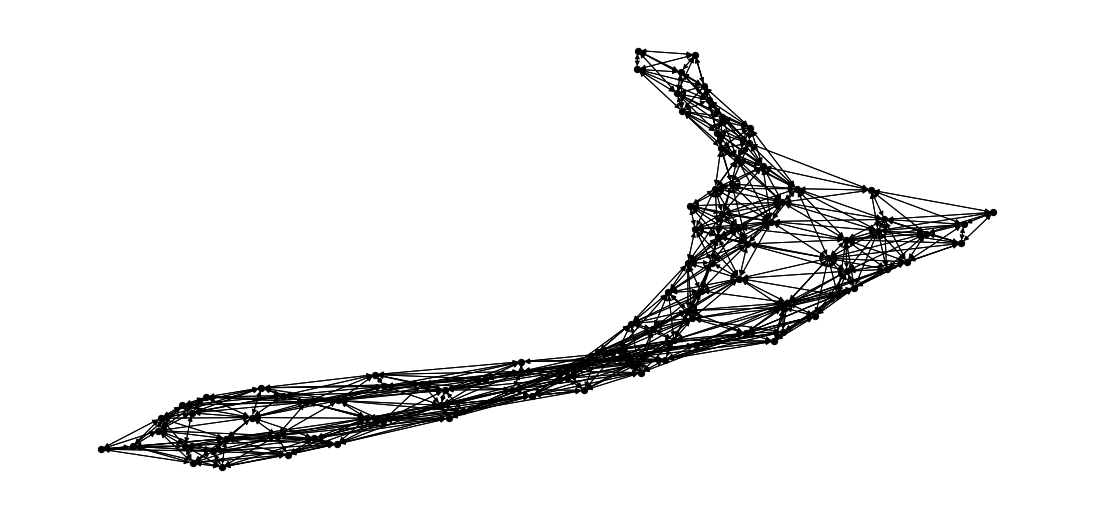

In [6]:
options = {
    'node_color': 'black',
    'node_size': 40,
    'width': 1,
}
G = nx.from_numpy_array(contact_map*dist_matrix)
G.remove_edges_from(nx.selfloop_edges(G))
G = G.to_directed()
g = dgl.from_networkx(G, edge_attrs=['weight'])
g.ndata['feat'] = torch.tensor(OH_RES[[RES_NAMES[residue.get_resname()] for residue in model['A']]])
plt.figure(figsize=[15,7])
nx.draw(G, **options)
